In [ ]:
!pip install PyDrive

In [ ]:
!pip install gensim --upgrade
!pip install -U keras-tuner

     |████████████████████████████████| 24.2MB 135kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=98a3c82fc76f20d11f8cc206fd7e4fcde33f7bf11bc96dac2bd3efa4155d6ff4
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=eb17fbe2ae74583fa8e8c53d5b3078e5b72a66ec05a798fc63420af3e296da46
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Autorizar el acceso a tu propia cuenta de google drive, 
# siga el enlace, acepte y copie el codigo de verificación.

In [ ]:
# Model Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from gensim.models.keyedvectors import KeyedVectors
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from os import getcwd

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# File Extraction
myfile = drive.CreateFile({'id': '1eOTGLFbP2nhf9YBNC34vQre5pQ4pl1jY'})
myfile.GetContentFile('Base_Tweets.csv')

In [ ]:
# Reading File
df = pd.read_csv('Base_Tweets.csv', encoding = 'utf8')
df.head()

,content,polarity
0,Qué gusto escuchar a una mujer como Maria Blas...,P
1,Es más fácil levantarse por la mañana para cor...,P
2,La presidenta aavv de amigos del canódromo den...,N
3,"Asi es, eso es lo q importa RT @el_cuartel: @m...",P
4,El @PSOE pone pegas ahora a encorsetar el gast...,N


In [ ]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('spanish')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X_raw=np.array(df.content)
y=np.array(df.polarity)

print(X_raw.shape)
print(y.shape)

print(X_raw[0])
print(process_tweet(X_raw[0]))

(42367,)
(42367,)
Qué gusto escuchar a una mujer como Maria Blasco.....y encima nos deja titulares esperanzadores....
['gusto', 'escuchar', 'mujer', 'maria', 'blasco', '...', 'encima', 'deja', 'titular', 'esperanzador', '...']


In [ ]:
preprocess_list = np.array([process_tweet(x) for x in X_raw])
print(preprocess_list.shape)

(42367,)


In [ ]:
# Word to vector
maxlen = 100 #max number of word
max_words = 20000 #considers the first 20000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(preprocess_list)
sequences = tokenizer.texts_to_sequences(preprocess_list)

In [ ]:
import pickle

with open('tokenizer_bbva3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Word idctionary
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 41457 unique tokens.


In [ ]:
# Label Vector
sent_dic = dict(zip(df.polarity.unique(), range(len(df.polarity.unique()))))
df["Sent_Code"] = [sent_dic[x] for x in df.polarity]
Y = keras.utils.to_categorical(df.Sent_Code)

In [ ]:
# Shape of data
labels = np.asarray(Y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (42367, 100)
Shape of label tensor: (42367, 2)


In [ ]:
# Data Shuffle
indices = np.arange(data.shape[0])
np.random.seed(170298)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Dataset Split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = .3)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = .5)

In [ ]:
print(x_train.shape)
print(x_val.shape)

(29656, 100)
(6355, 100)


In [ ]:
# Import Embedding
myfile = drive.CreateFile({'id': '1TJ5XroELn2aMQKgvSCajA5juqKqQ7Zam'})
myfile.GetContentFile('sbw_vectors.bin')

embedd = KeyedVectors.load_word2vec_format("sbw_vectors.bin", binary=True)

In [ ]:
model = Sequential()
model.add(embedd.get_keras_embedding(train_embeddings = False, word_index = word_index))
model.add(GRU(16, dropout = 0.1, recurrent_dropout = 0.2, return_sequences = True))
model.add(LSTM(64, return_sequences = True))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         12437400  
_________________________________________________________________
gru (GRU)                    (None, None, 16)          15264     
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          20736     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

In [ ]:
# Compilation

from keras.callbacks import ModelCheckpoint
from keras import optimizers

batch=337

#model.compile(optimizer=optimizers.Adam(lr=.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['acc']) 

checkpointer = ModelCheckpoint(filepath= "Modelo_Ian_7.h5", monitor='val_acc', verbose=0, 
                               save_best_only=True, mode='max', period=1)

history = model.fit(x_train, y_train, epochs=25, batch_size=batch, steps_per_epoch=x_train.shape[0]//batch, validation_data=(x_val, y_val), 
                    callbacks=[checkpointer])

Epoch 1/25
88/88 [==============================] - 14s 156ms/step - loss: 0.2290 - acc: 0.9070 - val_loss: 0.3232 - val_acc: 0.8681
Epoch 2/25
88/88 [==============================] - 13s 144ms/step - loss: 0.2254 - acc: 0.9067 - val_loss: 0.3200 - val_acc: 0.8655
Epoch 3/25
88/88 [==============================] - 13s 144ms/step - loss: 0.2224 - acc: 0.9099 - val_loss: 0.3325 - val_acc: 0.8606
Epoch 4/25
88/88 [==============================] - 13s 149ms/step - loss: 0.2188 - acc: 0.9122 - val_loss: 0.3281 - val_acc: 0.8677
Epoch 5/25
88/88 [==============================] - 13s 143ms/step - loss: 0.2127 - acc: 0.9150 - val_loss: 0.3325 - val_acc: 0.8675
Epoch 6/25
88/88 [==============================] - 13s 143ms/step - loss: 0.2149 - acc: 0.9118 - val_loss: 0.3310 - val_acc: 0.8651
Epoch 7/25
88/88 [==============================] - 13s 144ms/step - loss: 0.2141 - acc: 0.9132 - val_loss: 0.3253 - val_acc: 0.8669
Epoch 8/25
88/88 [==============================] - 13s 143ms/step - 

In [ ]:
!mkdir -p saved_model
model.save('saved_model/model_Ian_6.h5') 

In [ ]:
model.evaluate(x_test, y_test)

199/199 [==============================] - 5s 27ms/step - loss: 0.3572 - acc: 0.8730


[0.35721632838249207, 0.873033344745636]

0.8758653241032096


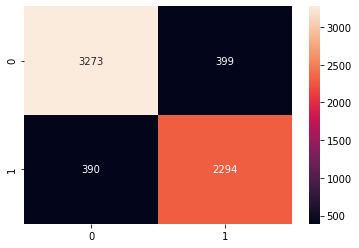

In [ ]:

# Prediction and confussion matrix
#predic = model.predict_classes(x_test)
predic = (model.predict_proba(x_test)[:,1] >= 0.448)
true = [np.argmax(x) for x in y_test]

cm = confusion_matrix(true, predic)
heatmap(cm, annot = True, fmt = 'd')
resultado = (cm[0][0] + cm[1][1]) / y_test.shape[0]
print(resultado)

In [ ]:
import tensorflow as tf
import kerastuner as kt
print(tf.__version__)
print(kt.__version__)

2.3.0
1.0.1
